# Click Through Rate Prediction


This work is adapted from my contribution to a final project for w261 Machine Learning at Scale. 

In this project, we aimed to build a model that predicts the probability that a user will click on an ad based on data from Criteo, a publisher, via [Kaggle](https://www.kaggle.com/c/criteo-display-ad-challenge/data). Our model was evaluated in terms of logaritmic loss. The data provided include a label (0 or 1) denoting a click or non-click,  13 integer features, and 26 categorical features, which the latter being hashed for anonymity of the users and advertisers. To further maintain privacy and anonymity, Criteo had also withheld feature identification, which posed some challenges in our modeling. This made it difficult to see whether certain values are outliers or what feature transformations would or would not make sense. However, this also forced us to closely examine the data and placed less emphasis on any assumptions we might have had about what goes into predicting the probability that a user will click on the ad.

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

# Context

In the current landscape of digital advertising, both advertisers, the entities paying for the ads, and publishers, the entities actually displaying the ad, need to accurately predict the efficacy of ads based on different variables and contexts. One of the metrics that determine the effectiveness of ads is click-through rate (CTR), which refers to how many users clicked on the ad after it was shown to them. CTR is also important in terms of defining the cost of the ad such that publishers may charge advertisers by cost per click. Publishers set up auctions in which advertisers can bid for an expected cost per impression, which is based on the probability for a click through or conversion through the ad. 

There are many challenges when it comes to predicting these probabilities. First, publishers continuously receive large amounts of web traffic, generating large volumes of data. Due to the nature of the advertising market, models need to be updated through training with new data to maintain performance. Additionally, these data are very high dimensional, but also tend to be very sparse. This data may come from different sources: publishers, advertisers, users, and time. The features may include:

* context features: website ID, domain ID, device type, etc.
* content features: the text inside the ad, size of the ad, media type, etc.
* user features: user ID, registered user, etc. 
* feedback features: click/no click

Given these challenges, models that predict CTR must be performative at scale in production. They must be able to handle high dimensionality as well as large amounts of data with the ability to retrain and update the model easily. 

# Exploratory Data Analysis

Since the provided training dataset is over 45 million rows even prior to performing random splits to preserve portions of the data for development and testing, performing exploratory data analysis (EDA) on the full dataset will be challenging. For most of our EDA, we utilized a random sample of a little less than 11,000 rows from the trainRDD after we split the large training data into trainRDD, devRDD, and testRDD. To obtain this sample, we utilized GCP to produce a text file to import into the notebook. We used Spark jobs for our analysis as well as Pandas, Matplotlib, and Seaborn for visualization.

First, we examined the overall click through rate (CTR) to get a sense of how balanced the training dataset is, especially given that it has over 45 million rows. We found a CTR rate of a little over 25% in the large training dataset through GCP and confirmed that our EDA sample has approximately the same proportion.

In [6]:
# read in the EDA text file with the EDA sample
f = open("eda.txt", "r")
eda = ast.literal_eval(f.read())
f.close()

# modified version of Dili's function
def parse_eda_row(row):
    '''
    for each row in the raw data,  outputs the following tuple:
        - (label, features_vector)
        where features_vector is comma separated string of features
        features with no value are replaced by empty string ''
    '''
    row_values = row.split('\t')
    # added modification here
    new_values = ["'" + value + "'" if value != '' else "''" for value in row_values[1:]]
    output_string = ",".join(new_values)
    return (row_values[0], output_string)

eda_rdd = sc.parallelize(eda)
# parse each row and return in list form for pandas
eda_pd = eda_rdd.map(lambda x: x.split('\t')).collect()
# parsed eda rdd
parsed_eda = eda_rdd.map(parse_eda_row).cache()

# create pandas dataframe for visualizations
features = ['label'] + list(range(1, 40))
eda_df = pd.DataFrame(eda_pd, columns = features)
# replace all the empty strings with NaN values
eda_df = eda_df.replace(r'^\s*$', np.nan, regex=True)

# calculate click through rate
ctr = eda_rdd.map(lambda x: x.split('\t')).filter(lambda x: x[0] == '1').count() / eda_rdd.map(lambda x: x.split('\t')).count()

print("EDA row count:", len(eda_pd))
print("EDA sample CTR: {:.2f}%".format(ctr * 100))

EDA row count: 10758
EDA sample CTR: 25.57%


### Missing Values by Feature
Our analysis showed that there are some columns with a big portion of missing values with some having over 76% of the values missing. Even if we performed some form of imputation, this may lead to bias in our model. Thus, this provided support in excluding the following features in our model: 1, 10, 12, 32, 33, 35, 38, and 39. We also noted that there are 15 features that have no missing values. There are a few features that share the same number of missing values, which suggested that some rows might have more missing values than others.

In [7]:
def feat_emissions(row):
    """
    For each key-value pair, parse the features from string representation 
    and emit numerical feature keys, the value, and 1 count
    """
    label, values = row
    values = ast.literal_eval(values)
    
    for key, val in enumerate(values, start = 1):
        yield (str(key), val, 1)

row_count = parsed_eda.count()
total = sc.broadcast(row_count)

na_counts = parsed_eda.flatMap(feat_emissions) \
                      .filter(lambda x: x[1] == '') \
                      .map(lambda x: (x[0], x[2])) \
                      .reduceByKey(lambda a, b: a + b) \
                      .map(lambda x: (x[0], x[1], x[1]/total.value)) \
                      .sortBy(lambda x: x[2], ascending = False) \
                      .collect()

for feat in na_counts:
    print('Feature {}  | {} NAs  | {:.2f}%'.format(feat[0], feat[1], feat[2]*100))

na_feats = [int(feat[0]) for feat in na_counts]

no_nas = []

for n in range(1, 40):
    if n not in na_feats:
        no_nas.append(n)

print("\nThe following features have no missing values:", no_nas)

Feature 12  | 8215 NAs  | 76.36%
Feature 35  | 8202 NAs  | 76.24%
Feature 1  | 4866 NAs  | 45.23%
Feature 10  | 4866 NAs  | 45.23%
Feature 33  | 4717 NAs  | 43.85%
Feature 32  | 4717 NAs  | 43.85%
Feature 38  | 4717 NAs  | 43.85%
Feature 39  | 4717 NAs  | 43.85%
Feature 6  | 2494 NAs  | 23.18%
Feature 4  | 2325 NAs  | 21.61%
Feature 13  | 2325 NAs  | 21.61%
Feature 3  | 2290 NAs  | 21.29%
Feature 19  | 1284 NAs  | 11.94%
Feature 9  | 499 NAs  | 4.64%
Feature 7  | 499 NAs  | 4.64%
Feature 11  | 499 NAs  | 4.64%
Feature 16  | 364 NAs  | 3.38%
Feature 17  | 364 NAs  | 3.38%
Feature 29  | 364 NAs  | 3.38%
Feature 34  | 364 NAs  | 3.38%
Feature 25  | 364 NAs  | 3.38%
Feature 37  | 364 NAs  | 3.38%
Feature 5  | 282 NAs  | 2.62%
Feature 8  | 4 NAs  | 0.04%

The following features have no missing values: [2, 14, 15, 18, 20, 21, 22, 23, 24, 26, 27, 28, 30, 31, 36]


### Missing Values by Row

We also examined missing values from the row perspective both generally and specifically for rows with the click (1) and non-click (0) labels. The plot below shows the distribution of missing values for all rows for this EDA sample. There are 186 rows that don't have any missing values at all, which is approximately 2% of this sample. In general, we noted that there are a handful of rows that are missing 20-22 values out of the 39 features. It appears that on average, a row will have about 5 missing values. We looked at the distributions of the click and non-click examples separately in case we found that one class tended to have more missing values than the other. Our analysis discovered that the distribution of missing values per row are similar for rows that are clicks versus non-clicks. 

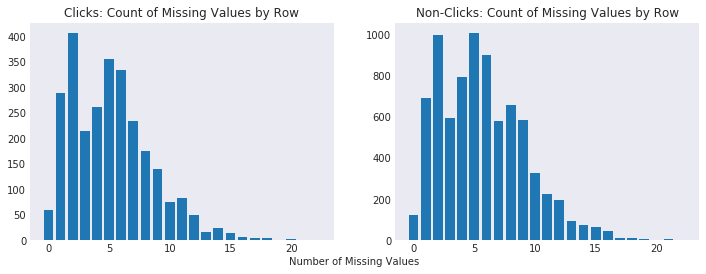

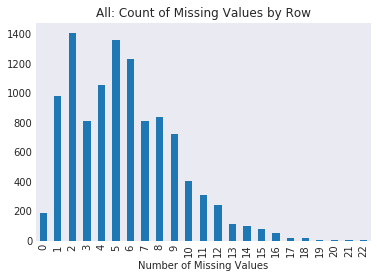

In [8]:
def row_na_count(row, emit_label = False):
    """
    For each row, parses the values and counts the missing values.
    If emit_label = True, then emits a key-value pair that has the label (0 or 1)
    If emit_label = False, then emits a key-value pair that has only the count
    """
    
    label, values = row
    values = ast.literal_eval(values)
    
    count = 0
    for val in values:
        if val == '':
            count += 1
    
    if emit_label:
        return ((label, count), 1)
    else:
        return (count, 1)

# get the missing values for all rows
row_na_counts = parsed_eda.map(row_na_count) \
                          .reduceByKey(lambda a, b: a + b) \
                          .collect()

# get missing values for rows that resulted in clicks
click_row_na = parsed_eda.map(lambda x: row_na_count(x, emit_label = True)) \
                        .filter(lambda x: x[0][0] == '1') \
                        .reduceByKey(lambda a, b: a + b) \
                        .map(lambda x: (x[0][1], x[1])) \
                        .collect()

# get missing values for rows that resulted in non-clicks
noclick_row_na = parsed_eda.map(lambda x: row_na_count(x, emit_label = True)) \
                        .filter(lambda x: x[0][0] == '0') \
                        .reduceByKey(lambda a, b: a + b) \
                        .map(lambda x: (x[0][1], x[1])) \
                        .collect()

# create pandas dataframes for plotting
row_df = pd.DataFrame(row_na_counts).sort_values(by = [0])
row_df.set_index(0, inplace = True)
click_df = pd.DataFrame(click_row_na).sort_values(by = [0])
click_df.set_index(0, inplace = True)
noclick_df = pd.DataFrame(noclick_row_na).sort_values(by = [0])
noclick_df.set_index(0, inplace = True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

row_df.plot(kind = 'bar', legend = None)
plt.title("All: Count of Missing Values by Row")
plt.xlabel("Number of Missing Values")

ax1.bar(click_df.index.values, click_df[1])
ax1.title.set_text("Clicks: Count of Missing Values by Row")

ax2.bar(noclick_df.index.values, noclick_df[1])
ax2.title.set_text("Non-Clicks: Count of Missing Values by Row")

fig.text(0.5, 0.04, "Number of Missing Values", ha='center')
plt.show()

### Examining the Integer Features

The following plots show that there is heavy positive skew for all of the integer features. For most of the integer features, the most frequent values are very small with the bins closest to zero being the biggest. The histograms also showed us that the features are on vastly different scales. For example, Feature 1 ranges from 0 to 200 while Feature 3 ranges from 0 to 40000. This suggested that these features need to undergo scaling as a part of preprocessing prior to modeling. 

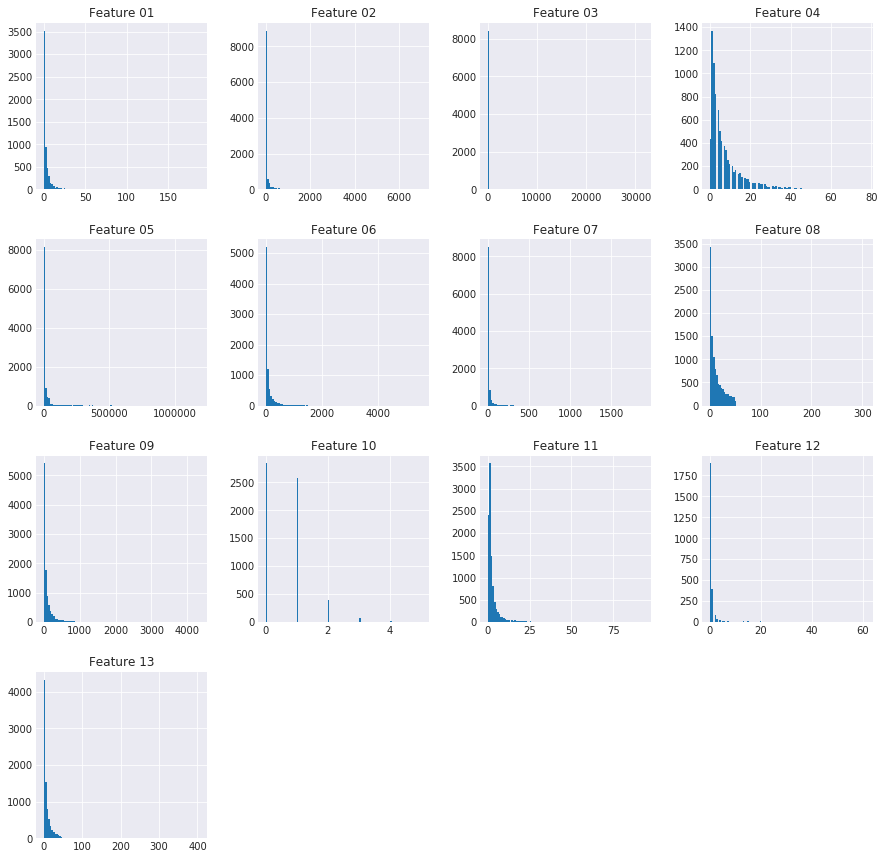

In [11]:
int_cols = ['Feature 0' + str(n) if n < 10 else 'Feature ' + str(n) for n in range(1, 14)]
pd.DataFrame(np.float64(eda_df[features[1:14]]), columns = int_cols).hist(figsize = (15, 15), bins = 100)
plt.show()

We also performed correlation analysis between different pairings of the integer features as shown below. There are strong positive correlations for the following pairs: Features 4 and 13, Features 7 and 11, Features 8 and 13, Features 4 and 8. There is a moderate negative correlation for Features 5 and 10 and Features 6 and 10. This is important to consider as we build the model so we can avoid collinearity.

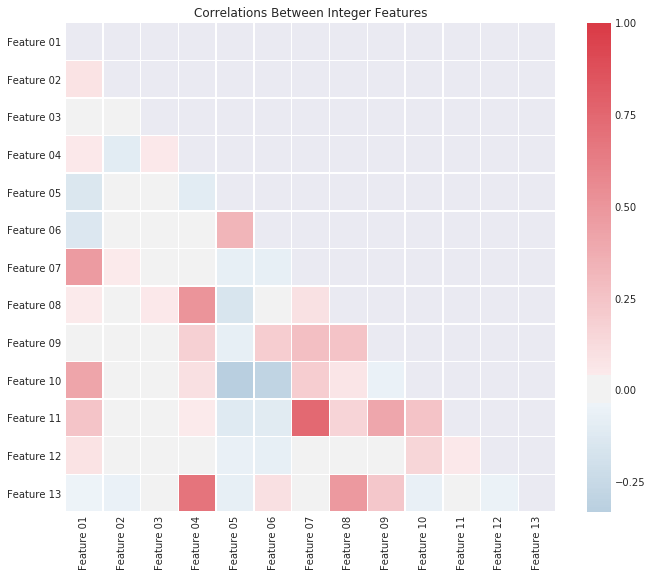

In [12]:
corr = pd.DataFrame(np.float64(eda_df[features[1:14]]), columns = int_cols).corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations Between Integer Features")
plt.show()

### Examining the Categorical Features

With 39 features total and 26 of them being categorical, our dataset has the potential to increase in dimensionality. It is not feasible to one-hot encode by every category within the categorical features. Thus, we need to get a sense of how many unique categories are in each feature in order to determine approaches to binning and one-hot encoding. Based on the sample we took for EDA, Features 16, 17, 20, 23, 25, 29, 34, and 39 contain the most unique categories with over 30% of the categories being unique. feature 16 has the most unique categories at over 60%. Besides Feature 39, the other features do not have many missing values. 

In [9]:
def cat_feat_emissions(row, filter_feats = None):
    """
    For each key-value pair, parse the categorical features from string representation 
    and emit composite key for feature number and value and 1 count
    """
    label, values = row
    values = ast.literal_eval(values)
    
    emissions = []
    
    for key, val in enumerate(values[13:], start = 14):
        if filter_feats != None:
            if val != '' and str(key) in filter_feats:
                emissions.append((str(key) + "-" + val, 1))
        else:
            if val != '':
                emissions.append((str(key) + "-" + val, 1))
    
    return emissions

# parse the categorical features and create composite keys with the feature number and categorical value
# to detect unique categories within each feature
uniq_rdd = parsed_eda.flatMap(cat_feat_emissions) \
                    .reduceByKey(lambda a, b: a + b) \
                    .map(lambda x: (x[0].split("-")[0], 1)) \
                    .reduceByKey(lambda a, b: a + b) \
                    .cache()

# join with calculation of how many non-missing values are in the feature to get a sense of uniqueness
nonna_rdd = parsed_eda.flatMap(feat_emissions) \
                      .filter(lambda x: x[1] != '') \
                      .map(lambda x: (x[0], x[2])) \
                      .reduceByKey(lambda a, b: a + b) \
                      .join(uniq_rdd) \
                      .map(lambda x: (x[0], (x[1][0], x[1][1], x[1][1]/x[1][0]))) \
                      .cache()

cat_uniq = nonna_rdd.sortBy(lambda x: x[1][2], ascending = False).collect()

for feat in cat_uniq:
    print("Feature {} | Unique Count: {:.0f} | Total Non-NaN: {} | {:.2f}% unique".format(feat[0], feat[1][1], feat[1][0], feat[1][2] * 100))

Feature 16 | Unique Count: 6325 | Total Non-NaN: 10394 | 60.85% unique
Feature 25 | Unique Count: 5939 | Total Non-NaN: 10394 | 57.14% unique
Feature 34 | Unique Count: 5689 | Total Non-NaN: 10394 | 54.73% unique
Feature 29 | Unique Count: 5355 | Total Non-NaN: 10394 | 51.52% unique
Feature 17 | Unique Count: 4525 | Total Non-NaN: 10394 | 43.53% unique
Feature 39 | Unique Count: 2110 | Total Non-NaN: 6041 | 34.93% unique
Feature 20 | Unique Count: 3514 | Total Non-NaN: 10758 | 32.66% unique
Feature 23 | Unique Count: 3469 | Total Non-NaN: 10758 | 32.25% unique
Feature 37 | Unique Count: 2810 | Total Non-NaN: 10394 | 27.03% unique
Feature 24 | Unique Count: 2216 | Total Non-NaN: 10758 | 20.60% unique
Feature 28 | Unique Count: 2179 | Total Non-NaN: 10758 | 20.25% unique
Feature 26 | Unique Count: 1830 | Total Non-NaN: 10758 | 17.01% unique
Feature 31 | Unique Count: 1245 | Total Non-NaN: 10758 | 11.57% unique
Feature 32 | Unique Count: 559 | Total Non-NaN: 6041 | 9.25% unique
Feature 15

We examined the frequency counts of respective categories in these "highly unique" features and found that a big percentage of the unique categories only appear once. For example, Feature 16 has the most unique categories, but almost 90% of these have a frequency count of 1. Perhaps this means that Feature 16 is some kind of unique identifier such as user ID. Given that these features contain so many unique categories, we argue that these features will likely have low predictive value and will exclude them in our feature selection. 

In [10]:
# get the count of categories that only appear once in the "highly unique features" (> 30% unique)

low_freq = parsed_eda.flatMap(cat_feat_emissions) \
        .reduceByKey(lambda a, b: a + b) \
        .filter(lambda x: x[1] == 1) \
        .map(lambda x: (x[0].split("-")[0], 1)) \
        .reduceByKey(lambda a, b: a + b) \
        .join(nonna_rdd) \
        .map(lambda x: (x[0], (x[1][0], x[1][1][2], x[1][1][1], x[1][0]/x[1][1][1]))) \
        .sortBy(lambda x: x[1][1], ascending = False) \
        .take(8)

for feat in low_freq:
    print("Feature {} | One-offs: {} | Total Unique: {:.0f} | {:.2f}%".format(feat[0], feat[1][0], feat[1][2], feat[1][3] * 100))

Feature 16 | One-offs: 5644 | Total Unique: 6325 | 89.23%
Feature 25 | One-offs: 5235 | Total Unique: 5939 | 88.15%
Feature 34 | One-offs: 4960 | Total Unique: 5689 | 87.19%
Feature 29 | One-offs: 4577 | Total Unique: 5355 | 85.47%
Feature 17 | One-offs: 3657 | Total Unique: 4525 | 80.82%
Feature 39 | One-offs: 1485 | Total Unique: 2110 | 70.38%
Feature 20 | One-offs: 1860 | Total Unique: 3514 | 52.93%
Feature 23 | One-offs: 2234 | Total Unique: 3469 | 64.40%


We utilized Breiman's algorithm in our strategy of binning the remaining categorical features. Since there are more non-clicks than clicks in the data, many of the categories have ranks closer to zero after we applied the algorithm. 

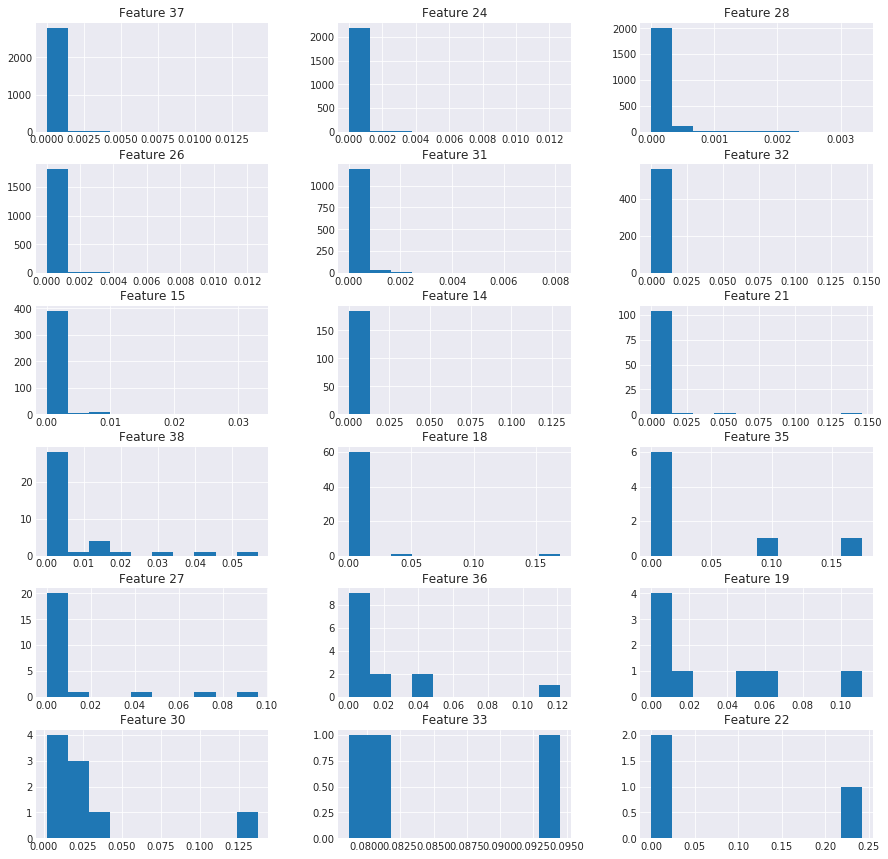

In [40]:
def cat_feats_label(row, filter_feats):
    """
    For each key-value pair, parse the categorical features from string representation 
    and emit composite key for feature number and value and 1 count
    """
    label, values = row
    values = ast.literal_eval(values)
    
    emissions = []
    
    for key, val in enumerate(values[13:], start = 14):
        if val != '' and str(key) in filter_feats:
            if label == '1':
                emissions.append((str(key) + "-" + val, 1))
            elif label == '0':
                emissions.append((str(key) + "-" + val, 0))
    
    return emissions

def format_result(pair):
    """ 
    Takes the pair and splits the composite key into separate values
    and calculates total outcome to frequency ratio
    """
    key, vals = pair
    feat, cat = vals[0][0].split("-")
    
    return (key, cat, vals[0][1]/vals[1])

# since we're excluding the highly unique categories, we'll get the remaining features 
# and broadcast as a way to filter
remaining_feats = [feat[0] for feat in cat_uniq[8:]]
filter_feats = sc.broadcast(remaining_feats)

# get category frequencies for just the remaining features
freq_rdd = parsed_eda.flatMap(feat_emissions) \
                     .filter(lambda x: x[0] in filter_feats.value) \
                      .filter(lambda x: x[1] != '') \
                      .map(lambda x: (x[0], x[2])) \
                       .reduceByKey(lambda a, b: a + b) \

# get the outcome counts for these categories and join with frequency rdd
# format the result for pandas
binning = parsed_eda.flatMap(lambda x: cat_feats_label(x, filter_feats.value)) \
                    .reduceByKey(lambda a, b: a + b) \
                    .map(lambda x: (x[0].split("-")[0], (x[0], x[1]))) \
                    .join(freq_rdd) \
                    .map(format_result) \
                    .collect()

# create pandas dataframe for visualization
binning_df = pd.DataFrame(binning)

fig, axes = plt.subplots(6, 3, figsize=(15, 15))

# indices for the subplots
n = 0
m = 0

# loop through the results to plot distribution of the ratios for binning categorical variables
for feat in remaining_feats:
    binning_df[binning_df[0] == feat].hist(bins = 10, ax = axes[m, n])
    title = "Feature " + feat
    axes[m, n].title.set_text(title)
    # update and reset the indices accordingly
    if n < 2:
        n += 1
    elif n == 2:
        n = 0
        m += 1

#fig.savefig('binning_eda_updated.png')
plt.show()

## Sources

Chapelle, O., Manavoglu, E., & Rosales, R. (2014). Simple and Scalable Response Prediction for Display Advertising. ACM Transactions on Intelligent Systems and Technology, 5(4), 1-34. doi:10.1145/2532128

He, X., Bowers, S., Candela, J. Q., Pan, J., Jin, O., Xu, T., . . . Herbrich, R. (2014). Practical Lessons from Predicting Clicks on Ads at Facebook. Proceedings of 20th ACM SIGKDD Conference on Knowledge Discovery and Data Mining - ADKDD14. doi:10.1145/2648584.2648589